##Import libraries

In [26]:
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.2.4
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ngg7_seg
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ngg7_seg


In [27]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
from ast import literal_eval
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
import string
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Import data and data preprocessing

In [28]:
# Import data
tsd_train = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_train.csv')
tsd_test = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_test.csv')
tsd_trial = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_trial.csv')

# Convert spans from string to list
tsd_train['spans'] = tsd_train['spans'].apply(literal_eval)
tsd_test['spans'] = tsd_test['spans'].apply(literal_eval)
tsd_trial['spans'] = tsd_trial['spans'].apply(literal_eval)

tsd_train.head(10)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA..."
5,[],"But, but, but, is NOT a defense. It's not eve..."
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","Please people, stop using these silly, stupid ..."
7,"[0, 1, 2, 3]",Dumb.
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",Obamacare is on it's last gasping breaths. Y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",CROOKED Trump = GUILTY as hell.\npathetic


## Preprocessing

Replace \n, emojis, and lowercase all characters

In [29]:
# Lowercase all characters
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.lower())
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.lower())
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.lower())

# Replace \n by space, so the index won't be effected
# Replace emojis by ?
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.replace('\n', ' '))
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

tsd_test['text'] = tsd_test['text'].apply(lambda x: x.replace('\n', ' '))
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.replace('\n', ' '))
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

# Remove punctuations
def remove_punctuation(text):
    punctuationfree = []
    for i in text:
        if i not in string.punctuation:
            punctuationfree.append(i)
        else:
            punctuationfree.append(' '*len(i))
    if punctuationfree[-1] == ' ':
        punctuationfree = punctuationfree[:-1]
    punctuationfree = ''.join(punctuationfree)
    return punctuationfree

tsd_train['text'] = tsd_train['text'].apply(lambda x: remove_punctuation(x))
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: remove_punctuation(x))
tsd_test['text'] = tsd_test['text'].apply(lambda x: remove_punctuation(x))

tsd_train.head(10)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","i am 56 years old, i am not your fucking junio..."
2,"[0, 1, 2, 3]","damn, a whole family. sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead. how can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?"" any..."
5,[],"but, but, but, is not a defense. it's not eve..."
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","please people, stop using these silly, stupid ..."
7,"[0, 1, 2, 3]",dumb.
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",obamacare is on it's last gasping breaths. y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",crooked trump = guilty as hell. pathetic


## Prepare data

In [30]:
def find_toxic_words(span, text):
    i = 0
    token = []
    a = 0

    word = []

    while (i < (len(span) - 1)):
        if (span[i] != (span[i+1]-1)):
            token.append(span[a:(i+1)])
            a = i + 1
        elif i == (len(span) - 2):
            token.append(span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def BIO_tagger(span, text, get_span=0):
    tknzr2 = TweetTokenizer()
    tmp_tokens = tknzr2.tokenize(text)
    tokens = []
    token_span = []
    for each_token in tmp_tokens:
        if each_token not in string.punctuation:
            tokens.append(each_token)
            if get_span == 1:
                if len(token_span) != 0:
                    tmp = text[token_span[len(token_span)-1][-1]+1:]
                    start = tmp.find(each_token) + token_span[len(token_span)-1][-1]+1
                    token_span.append(list(range(start, start + len(each_token))))
                else:
                    token_span.append(list(range(0, len(each_token))))

    sequence = []
    for each in tokens:
        sequence.append([each, 'O'])

    toxic_words = find_toxic_words(span, text)

    toxic_tokens = []
    for i in range(0, len(tokens)):
        for each_toxic in toxic_words:
            t = tknzr2.tokenize(each_toxic)
            if tokens[i] in t:
                if tokens[i] == t[0]:
                    sequence[i][1] = 'B'
                elif i != 0 and (sequence[i-1][1] == 'B' or sequence[i-1][1] == 'I'):
                    sequence[i][1] = 'I'

    return sequence, toxic_words, token_span

# Build a new dataframe to store tokens and tags
def encode(df, get_span=0):
    result_sequence  = []
    result_toxic_words = []
    result_token_span = []

    for index, row in df.iterrows():
        sequence, toxic_words, token_span = BIO_tagger(row['spans'], row['text'], get_span)
        result_sequence.append(sequence)
        result_toxic_words.append(toxic_words)
        result_token_span.append(token_span)

    df['sequence'] = result_sequence
    df['toxic_word'] = result_toxic_words
    if get_span == 1:
        df['token_span'] = result_token_span

encode(tsd_train)
encode(tsd_trial)
encode(tsd_test, 1)

tsd_train.head(10)

,spans,text,sequence,toxic_word
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...,"[[another, O], [violent, B], [and, I], [aggres...",[violent and aggressive immigrant]
1,"[33, 34, 35, 36, 37, 38, 39]","i am 56 years old, i am not your fucking junio...","[[i, O], [am, O], [56, O], [years, O], [old, O...",[fucking]
2,"[0, 1, 2, 3]","damn, a whole family. sad indeed.","[[damn, B], [a, O], [whole, O], [family, O], [...",[damn]
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead. how can anyone not know th...,"[[what, O], [a, O], [knucklehead, B], [how, O]...",[knucklehead]
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?"" any...","[[who, O], [do, O], [you, O], [think, O], [sho...",[killing]
5,[],"but, but, but, is not a defense. it's not eve...","[[but, O], [but, O], [but, O], [is, O], [not, ...",[]
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","please people, stop using these silly, stupid ...","[[please, O], [people, O], [stop, O], [using, ...","[stupid, emoticons]"
7,"[0, 1, 2, 3]",dumb.,"[[dumb, B]]",[dumb]
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",obamacare is on it's last gasping breaths. y...,"[[obamacare, O], [is, O], [on, O], [it's, O], ...","[idiots, stupid]"
9,"[32, 33, 34, 35, 36, 37, 38, 39]",crooked trump = guilty as hell. pathetic,"[[crooked, O], [trump, O], [guilty, O], [as, O...",[pathetic]


## Data Visualization

We need to find out the distribution of length of comments in order to determine the max_length

Text(0.5, 0, 'Length of comments')

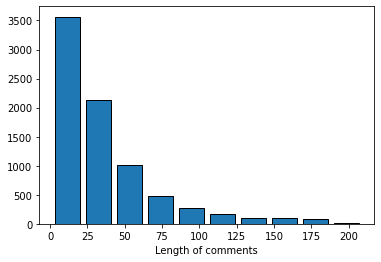

In [31]:
# Distribution histogram plot
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline

fig, ax = plt.subplots()

len_comment = []
for index, row in tsd_train.iterrows():
    len_comment.append(len(row['sequence']))

ax.hist(len_comment, density=False, edgecolor='k', rwidth=0.8)  # density=False would make counts

plt.xlabel('Length of comments')

## Convert tokens, tags to index

In [32]:
# Get all tokens from the data
def get_token():
    tokens = []

    for index, row in tsd_train.iterrows():
        sequence = row['sequence']
        for each in sequence:
            tokens.append(each[0])

    for index, row in tsd_trial.iterrows():
        sequence = row['sequence']
        for each in sequence:
            tokens.append(each[0])

    for index, row in tsd_test.iterrows():
        sequence = row['sequence']
        for each in sequence:
            tokens.append(each[0])

    tokens = list(set(tokens))

    return tokens

In [33]:
tokens = get_token()

# Token to index
token2idx = {w: i + 2 for i, w in enumerate(tokens)}
token2idx["UNK"] = 1 # Unknown tokens
token2idx["PAD"] = 0 # Padding

idx2token = {i: w for w, i in token2idx.items()}

# Tag to index
tag2idx = {}
tag2idx["PAD"] = 0
tag2idx["B"] = 1
tag2idx["I"] = 2
tag2idx["O"] = 3
idx2tag = {i: w for w, i in tag2idx.items()}

print('Number of tokens: ', len(token2idx))

Number of tokens:  23280


In [34]:
max_length = 100
embedding_dim = 25
max_features = 10000

def data_padding(df):
    sequences = list(df['sequence'].values)
    print(len(sequences))

    # Convert each sentence from list of Token to list of word_index
    X = [[token2idx[w[0]] for w in s] for s in sequences]
    # Padding each sentence to have the same lenght
    X = pad_sequences(maxlen=max_length, sequences=X, padding="post", value=token2idx["PAD"])

    # Convert Tag/Label to tag_index
    y = [[tag2idx[w[1]] for w in s] for s in sequences]
    # Padding each sentence to have the same lenght
    y = pad_sequences(maxlen=max_length, sequences=y, padding="post", value=tag2idx["PAD"])
    y = to_categorical(y, num_classes=4)

    return X, y

X_train, y_train = data_padding(tsd_train)
X_trial, y_trial = data_padding(tsd_trial)
X_test, y_test = data_padding(tsd_test)

7939
690
2000


## Build model

In [40]:
# BiLSTM
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.optimizers import Adam

# from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Flatten, Dropout, Input
# from tensorflow_addons.layers import CRF
# from tensorflow.keras.models import Model
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy

import warnings
warnings.filterwarnings("ignore")

input = Input(shape = (max_length,))
model = Embedding(input_dim=len(token2idx)+2,
                    output_dim=embedding_dim,
                    input_length=max_length,
                    trainable=True)(input)

model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units = max_length, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(max_length, activation="relu"))(model)

crf = CRF(4)  
out = crf(model)  # output

# out = Dense(4, activation="sigmoid", kernel_initializer='glorot_uniform')(model)  # output

model = Model(input, out)

adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
#model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 25)           582050    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 25)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          100800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 100)          20100     
____________________________________________________________

In [41]:
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

checkpointer = ModelCheckpoint(filepath = 'gdrive/MyDrive/CSI4900-Project/BIO_LSTM/my_model.epoch{epoch:02d}-loss{val_loss:.2f}.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

model.fit(X_train, np.array(y_train), batch_size=64, epochs=15, validation_data=(X_trial, y_trial))

# Save model
# model.save('gdrive/MyDrive/CSI4900-Project/BIO_LSTM/my_model.h5')




Train on 7939 samples, validate on 690 samples
Epoch 1/15





7939/7939 [==============================] - 99s 13ms/step - loss: 0.3315 - crf_viterbi_accuracy: 0.8760 - acc: 0.6635 - val_loss: 0.1236 - val_crf_viterbi_accuracy: 0.9746 - val_acc: 0.9746
Epoch 2/15
7939/7939 [==============================] - 96s 12ms/step - loss: 0.1317 - crf_viterbi_accuracy: 0.9702 - acc: 0.6635 - val_loss: 0.1054 - val_crf_viterbi_accuracy: 0.9758 - val_acc: 0.9758
Epoch 3/15
7939/7939 [==============================] - 95s 12ms/step - loss: 0.1139 - crf_viterbi_accuracy: 0.9712 - acc: 0.6635 - val_loss: 0.0906 - val_crf_viterbi_accuracy: 0.9761 - val_acc: 0.9761
Epoch 4/15
7939/7939 [==============================] - 94s 12ms/step - loss: 0.0972 - crf_viterbi_accuracy: 0.9735 - acc: 0.6635 - val_loss: 0.0847 - val_crf_viterbi_accuracy: 0.9781 - val_acc: 0.9781
Epoch 5/15
7939/7939 [==============================] - 95s 12ms/step - loss: 0.0872 - crf_viterbi_accuracy: 0.9755 - acc: 0.6635 - val_l

## Evaluation

We used the evaluation methods provided by Semantic Evaluation

In [39]:
# Read saved model
# NOTE: Skip this step, if you want to train the model yourself instead of read the saved model
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

model = load_model('gdrive/MyDrive/CSI4900-Project/BIO_LSTM/my_model.h5', custom_objects={'CRF':CRF,'crf_loss':crf_loss,'crf_accuracy':crf_accuracy})

AttributeError: ignored

In [43]:
# Define evaluation functions

import sys
from scipy.stats import sem
import numpy as np
from ast import literal_eval

def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)


def evaluate(pred, gold):
    """
    Based on https://github.com/felipebravom/EmoInt/blob/master/codalab/scoring_program/evaluation.py
    :param pred: file with predictions
    :param gold: file with ground truth
    :return:
    """
    # read the predictions
    pred_lines = pred.readlines()
    # read the ground truth
    gold_lines = gold.readlines()

    # only when the same number of lines exists
    if (len(pred_lines) == len(gold_lines)):
        data_dic = {}
        for n, line in enumerate(gold_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                data_dic[int(parts[0])] = [literal_eval(parts[1])]
            else:
                raise ValueError('Format problem for gold line %d.', n)

        for n, line in enumerate(pred_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                if int(parts[0]) in data_dic:
                    try:
                        data_dic[int(parts[0])].append(literal_eval(parts[1]))
                    except ValueError:
                        # Invalid predictions are replaced by a default value
                        data_dic[int(parts[0])].append([])
                else:
                    raise ValueError('Invalid text id for pred line %d.', n)
            else:
                raise ValueError('Format problem for pred line %d.', n)

        # lists storing gold and prediction scores
        scores = []
        for id in data_dic:
            if len(data_dic[id]) == 2:
                gold_spans = data_dic[id][0]
                pred_spans = data_dic[id][1]
                scores.append(f1(pred_spans, gold_spans))
            else:
                sys.exit('Repeated id in test data.')

        return (np.mean(scores), sem(scores))

    else:
        sys.exit('Predictions and gold data have different number of lines.')

In [44]:
y_predicted = model.predict(X_test)
y_predicted = np.argmax(y_predicted, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [45]:
pred_tag = [[idx2tag[i] for i in row] for row in y_predicted]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_test_true]

for index, row in tsd_test.iterrows():
    pred_tag[index] = pred_tag[index][:len(row['sequence'])]
    y_te_true_tag[index] = y_te_true_tag[index][:len(row["sequence"])]

### Evaluation based on predicted span

In [46]:
pred_spans = []
for i in range(0, len(pred_tag)):
    tmp = []
    for j in range(0, len(pred_tag[i])):
        if pred_tag[i][j] == "B" or pred_tag[i][j] == "I":
            tmp += tsd_test['token_span'][i][j]
    pred_spans.append(tmp)
tsd_test['pred_spans'] = pred_spans
tsd_test.head(10)

,spans,text,sequence,toxic_word,token_span,pred_spans
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that's right. they are not normal. and i am st...,"[[that's, O], [right, O], [they, O], [are, O],...","[abnormal, sexist rubbish]","[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [14, 1...","[140, 141, 142, 143, 144, 145, 146]"
1,"[81, 82, 83, 84, 85, 86]","""watch people die from taking away their healt...","[[watch, O], [people, O], [die, O], [from, O],...",[stupid],"[[0, 1, 2, 3, 4], [7, 8, 9, 10, 11, 12], [14, ...","[54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 6..."
2,[],tens years ago i contacted the pdr and suggest...,"[[tens, O], [years, O], [ago, O], [i, O], [con...",[],"[[0, 1, 2, 3], [5, 6, 7, 8, 9], [11, 12, 13], ...","[483, 484, 485, 486, 487, 488, 489, 490]"
3,[],the parallels between the anc and the sicilian...,"[[the, O], [parallels, O], [between, O], [the,...",[],"[[0, 1, 2], [4, 5, 6, 7, 8, 9, 10, 11, 12], [1...","[413, 414, 415, 416, 417, 418, 419, 420]"
4,[],intel community: ?how can we work for a presid...,"[[intel, O], [community, O], [how, O], [can, O...",[],"[[0, 1, 2, 3, 4], [6, 7, 8, 9, 10, 11, 12, 13,...","[350, 351, 352, 353, 616, 617, 619, 620]"
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,"[[i, O], [live, O], [in, O], [an, O], [area, O...",[stupid],"[[0], [2, 3, 4, 5], [7, 8], [10, 11], [13, 14,...","[129, 130, 131, 132, 133, 134]"
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath ?.,"[[elaine, O], [marie, O], [jeffers, O], [sound...",[sociopath],"[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [13, 1...","[35, 36, 37, 38, 39, 40, 41, 42, 43]"
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[[a, O], [rock, O], [has, O], [more, O], [ment...","[ignorant, dishonest people]","[[0], [2, 3, 4, 5], [7, 8, 9], [11, 12, 13, 14...","[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116..."
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...","ha ha, hillary lost. all you hillary fools nee...","[[ha, O], [ha, O], [hillary, O], [lost, O], [a...","[fools, dump, trash]","[[0, 1], [3, 4], [7, 8, 9, 10, 11, 12, 13], [1...","[37, 38, 39, 40, 41, 134, 135, 136, 137, 158, ..."
9,"[94, 95, 96, 97]",yes....it is to be expected....oddly enough it...,"[[yes, O], [..., O], [it, O], [is, O], [to, O]...",[dumb],"[[0, 1, 2], [3, 4, 5], [7, 8], [10, 11], [13, ...","[94, 95, 96, 97]"


In [47]:
f1_scores = []
for index, row in tsd_test.iterrows():
    score = f1(row['pred_spans'], row['spans'])
    f1_scores.append(score)
tsd_test['f1_scores'] = f1_scores

tsd_test.head(10)

,spans,text,sequence,toxic_word,token_span,pred_spans,f1_scores
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that's right. they are not normal. and i am st...,"[[that's, O], [right, O], [they, O], [are, O],...","[abnormal, sexist rubbish]","[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [14, 1...","[140, 141, 142, 143, 144, 145, 146]",0.482759
1,"[81, 82, 83, 84, 85, 86]","""watch people die from taking away their healt...","[[watch, O], [people, O], [die, O], [from, O],...",[stupid],"[[0, 1, 2, 3, 4], [7, 8, 9, 10, 11, 12], [14, ...","[54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 6...",0.244898
2,[],tens years ago i contacted the pdr and suggest...,"[[tens, O], [years, O], [ago, O], [i, O], [con...",[],"[[0, 1, 2, 3], [5, 6, 7, 8, 9], [11, 12, 13], ...","[483, 484, 485, 486, 487, 488, 489, 490]",0.000000
3,[],the parallels between the anc and the sicilian...,"[[the, O], [parallels, O], [between, O], [the,...",[],"[[0, 1, 2], [4, 5, 6, 7, 8, 9, 10, 11, 12], [1...","[413, 414, 415, 416, 417, 418, 419, 420]",0.000000
4,[],intel community: ?how can we work for a presid...,"[[intel, O], [community, O], [how, O], [can, O...",[],"[[0, 1, 2, 3, 4], [6, 7, 8, 9, 10, 11, 12, 13,...","[350, 351, 352, 353, 616, 617, 619, 620]",0.000000
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,"[[i, O], [live, O], [in, O], [an, O], [area, O...",[stupid],"[[0], [2, 3, 4, 5], [7, 8], [10, 11], [13, 14,...","[129, 130, 131, 132, 133, 134]",1.000000
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath ?.,"[[elaine, O], [marie, O], [jeffers, O], [sound...",[sociopath],"[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [13, 1...","[35, 36, 37, 38, 39, 40, 41, 42, 43]",1.000000
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[[a, O], [rock, O], [has, O], [more, O], [ment...","[ignorant, dishonest people]","[[0], [2, 3, 4, 5], [7, 8, 9], [11, 12, 13, 14...","[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",0.829268
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...","ha ha, hillary lost. all you hillary fools nee...","[[ha, O], [ha, O], [hillary, O], [lost, O], [a...","[fools, dump, trash]","[[0, 1], [3, 4], [7, 8, 9, 10, 11, 12, 13], [1...","[37, 38, 39, 40, 41, 134, 135, 136, 137, 158, ...",0.736842
9,"[94, 95, 96, 97]",yes....it is to be expected....oddly enough it...,"[[yes, O], [..., O], [it, O], [is, O], [to, O]...",[dumb],"[[0, 1, 2], [3, 4, 5], [7, 8], [10, 11], [13, ...","[94, 95, 96, 97]",1.000000


F1 = 0.62 ± 0.01


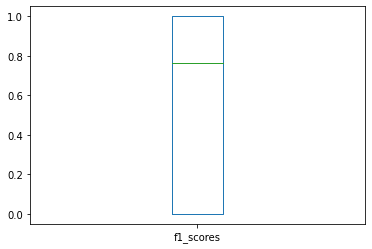

In [48]:
from scipy.stats import sem
_ = tsd_test.f1_scores.plot(kind="box")
print (f"F1 = {tsd_test.f1_scores.mean():.2f} ± {sem(tsd_test.f1_scores):.2f}")

In [49]:
# make sure that the ids match the ones of the scores
predictions = tsd_test.pred_spans.to_list()
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-pred-span.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-pred-span.txt

0	[140, 141, 142, 143, 144, 145, 146]
1	[54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 67, 71, 72, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 108]
2	[483, 484, 485, 486, 487, 488, 489, 490]
3	[413, 414, 415, 416, 417, 418, 419, 420]
4	[350, 351, 352, 353, 616, 617, 619, 620]
5	[129, 130, 131, 132, 133, 134]
6	[35, 36, 37, 38, 39, 40, 41, 42, 43]
7	[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116, 117, 118, 119, 120, 121, 122]
8	[37, 38, 39, 40, 41, 134, 135, 136, 137, 158, 159, 160, 161, 204, 205, 206, 207, 208, 321, 322, 323, 324, 325, 326]
9	[94, 95, 96, 97]


In [50]:
gold = tsd_test.spans.to_list()
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-gold-span.txt", "w") as out:
  for uid, text_scores in zip(ids, gold):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-gold-span.txt

0	[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
1	[81, 82, 83, 84, 85, 86]
2	[]
3	[]
4	[]
5	[129, 130, 131, 132, 133, 134]
6	[35, 36, 37, 38, 39, 40, 41, 42, 43]
7	[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
8	[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, 205, 206, 207, 208]
9	[94, 95, 96, 97]


In [51]:
predictions = open("gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-pred-span.txt", "r")
gold = open("gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-gold-span.txt", "r")

score = evaluate(predictions, gold)
print(score)

(0.6208094314727776, 0.009465477941296914)


### Evaluation based on toxic word

In [52]:
f1_scores = []
for i in range(0, len(y_test_true)):
    score = f1(pred_tag[i], y_te_true_tag[i])
    f1_scores.append(score)
tsd_test['f1_scores'] = f1_scores

tsd_test.head(10)

,spans,text,sequence,toxic_word,token_span,pred_spans,f1_scores
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that's right. they are not normal. and i am st...,"[[that's, O], [right, O], [they, O], [are, O],...","[abnormal, sexist rubbish]","[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [14, 1...","[140, 141, 142, 143, 144, 145, 146]",0.800000
1,"[81, 82, 83, 84, 85, 86]","""watch people die from taking away their healt...","[[watch, O], [people, O], [die, O], [from, O],...",[stupid],"[[0, 1, 2, 3, 4], [7, 8, 9, 10, 11, 12], [14, ...","[54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 6...",0.800000
2,[],tens years ago i contacted the pdr and suggest...,"[[tens, O], [years, O], [ago, O], [i, O], [con...",[],"[[0, 1, 2, 3], [5, 6, 7, 8, 9], [11, 12, 13], ...","[483, 484, 485, 486, 487, 488, 489, 490]",0.666667
3,[],the parallels between the anc and the sicilian...,"[[the, O], [parallels, O], [between, O], [the,...",[],"[[0, 1, 2], [4, 5, 6, 7, 8, 9, 10, 11, 12], [1...","[413, 414, 415, 416, 417, 418, 419, 420]",0.666667
4,[],intel community: ?how can we work for a presid...,"[[intel, O], [community, O], [how, O], [can, O...",[],"[[0, 1, 2, 3, 4], [6, 7, 8, 9, 10, 11, 12, 13,...","[350, 351, 352, 353, 616, 617, 619, 620]",0.500000
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,"[[i, O], [live, O], [in, O], [an, O], [area, O...",[stupid],"[[0], [2, 3, 4, 5], [7, 8], [10, 11], [13, 14,...","[129, 130, 131, 132, 133, 134]",1.000000
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath ?.,"[[elaine, O], [marie, O], [jeffers, O], [sound...",[sociopath],"[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [13, 1...","[35, 36, 37, 38, 39, 40, 41, 42, 43]",1.000000
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[[a, O], [rock, O], [has, O], [more, O], [ment...","[ignorant, dishonest people]","[[0], [2, 3, 4, 5], [7, 8, 9], [11, 12, 13, 14...","[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",0.800000
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...","ha ha, hillary lost. all you hillary fools nee...","[[ha, O], [ha, O], [hillary, O], [lost, O], [a...","[fools, dump, trash]","[[0, 1], [3, 4], [7, 8, 9, 10, 11, 12, 13], [1...","[37, 38, 39, 40, 41, 134, 135, 136, 137, 158, ...",1.000000
9,"[94, 95, 96, 97]",yes....it is to be expected....oddly enough it...,"[[yes, O], [..., O], [it, O], [is, O], [to, O]...",[dumb],"[[0, 1, 2], [3, 4, 5], [7, 8], [10, 11], [13, ...","[94, 95, 96, 97]",1.000000


F1 = 0.88 ± 0.00


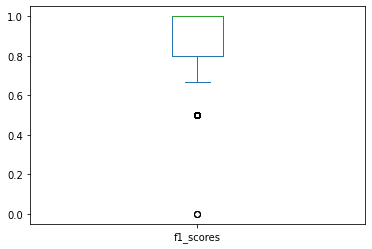

In [53]:
from scipy.stats import sem
_ = tsd_test.f1_scores.plot(kind="box")
print (f"F1 = {tsd_test.f1_scores.mean():.2f} ± {sem(tsd_test.f1_scores):.2f}")

In [54]:
# make sure that the ids match the ones of the scores
predictions = pred_tag
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-pred.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-pred.txt

0	['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O']
1	['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I']
2	['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O']
3	['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [55]:
gold = y_te_true_tag
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-gold.txt", "w") as out:
  for uid, text_scores in zip(ids, gold):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-gold.txt

0	['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O']
1	['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O']
2	['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
3	['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [56]:
predictions = open("gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-pred.txt", "r")
gold = open("gdrive/MyDrive/CSI4900-Project/BIO_LSTM/spans-gold.txt", "r")

score = evaluate(predictions, gold)
print(score)

(0.8847333333333334, 0.0037049208864620886)
